# core

> Some utility functions for working with PIL Images

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
# Import necessary modules from the standard library
from pathlib import Path  # For working with file paths
import hashlib
from glob import glob
import numpy as np  # For working with arrays
from PIL import Image  # For working with images

In [ ]:
#| export
def get_img_files(img_dir:Path, # The directory to search for image files
                    img_fmts=['jpg','jpeg','png'] # The list of image formats to search for
                   ):
    """
    Get all the image files in the given directory.
    
    Returns:
    img_paths (list): A list of pathlib.Path objects representing the image files
    """
    img_paths = []

    # Use the glob module to search for image files with specified formats
    for fmt in img_fmts:
        img_paths.extend(glob(f'{img_dir}/*.{fmt}'))
    # Convert the file paths to pathlib.Path objects
    img_paths = [Path(path) for path in img_paths]
    
    return img_paths

**Set the path for the images directory**

In [ ]:
img_dir = Path('../images/')
img_dir

Path('../images')

**Get a list of image file paths**

In [ ]:
img_paths = get_img_files(img_dir)
img_paths

[Path('../images/cat.jpg'), Path('../images/depth-cat.png')]

In [ ]:
#| export
def resize_img(img:'Image', # The image to be resized
               target_sz:int=512, # The target size of the image
               divisor:int=32 # The divisor value to crop the image
              ):
    """
    Resize the image to the target size, keeping aspect ratio 
    and crop the image if the size is not divisible by divisor.
    
    Returns:
    img (PIL.Image): The resized and possibly cropped image
    """
    # Find the minimum and maximum dimension of the image
    min_dim = np.argmin(img.size)
    max_dim = np.argmax(img.size)
    
    # Calculate the ratio of the minimum dimension to the target size
    ratio = min(img.size)/target_sz
    
    new_sz = []
    
    # Insert the target size to the minimum dimension of the image
    new_sz.insert(min_dim, target_sz)
    
    # Insert the maximum dimension of the image calculated based on the ratio
    new_sz.insert(max_dim, int(max(img.size)/ratio))
    
    # Resize the image to the new size
    img = img.resize(new_sz)
    
    # Crop the image if divisor is greater than 0
    if divisor > 0:
        src_w, src_h = img.size
        width = src_w if src_w%divisor==0 else src_w - src_w%divisor
        height = src_h if src_h%divisor==0 else src_h - src_h%divisor
        img = img.crop(box=(0, 0, width, height))
    
    return img

**Open sample image**

Image Size: (768, 512)


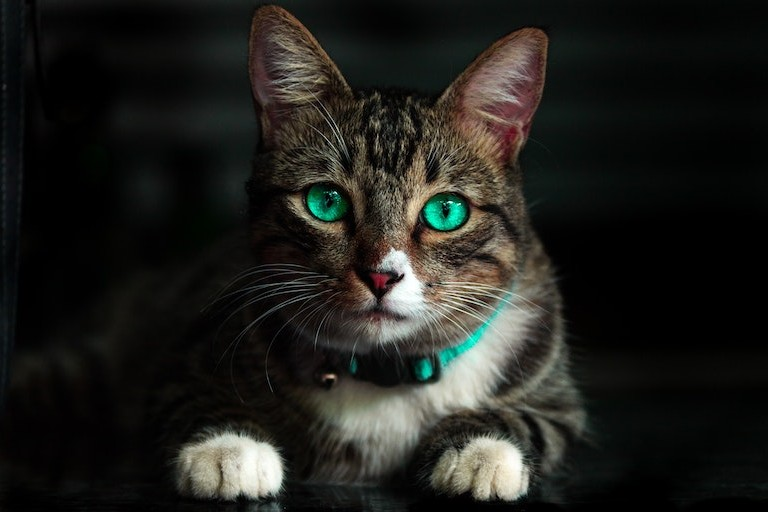

In [ ]:
img_path = img_paths[0]
src_img = Image.open(img_path).convert('RGB')
print(f"Image Size: {src_img.size}")
src_img

**Resize image**

New Image Size: (576, 384)


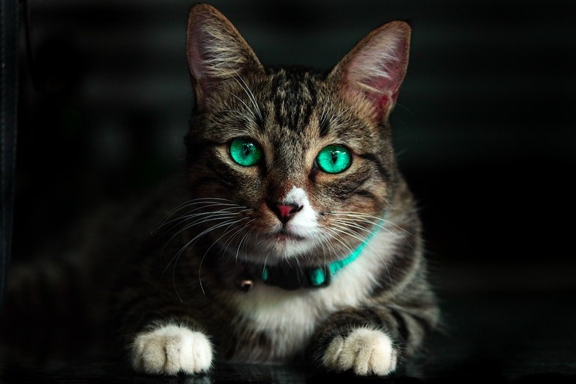

In [ ]:
resized_img = resize_img(src_img, target_sz=384, divisor=32)
print(f"New Image Size: {resized_img.size}")
resized_img

In [ ]:
#| export
def stack_imgs(imgs:['Image'] # A list of PIL.Image objects.
              ):
    """
    Stacks a list of images horizontally or vertically, depending on which dimension is larger.
    
    Returns:
    stack (PIL.Image): A single image containing all the input images stacked horizontally or vertically.
    """
    # Get the size of the first image in the list
    w,h = imgs[0].size
    
    # If the width is larger than the height, stack the images vertically
    if w >= h:
        # Create a new RGB image with the appropriate size
        stack = Image.new('RGB', size=(w, len(imgs)*h))
        
        # Iterate through the list of images and paste each image into the stack
        for i, img in enumerate(imgs): 
            stack.paste(img, box=(0, i*h, w, (i+1)*h))
    
    # If the height is larger than the width, stack the images horizontally
    else:
        # Create a new RGB image with the appropriate size
        stack = Image.new('RGB', size=(len(imgs)*w, h))
        
        # Iterate through the list of images and paste each image into the stack
        for i, img in enumerate(imgs): 
            stack.paste(img, box=(i*w, 0, (i+1)*w, h))
    
    # Return the resulting stacked image
    return stack

**Stack images**

Stacked Image Size: (576, 768)


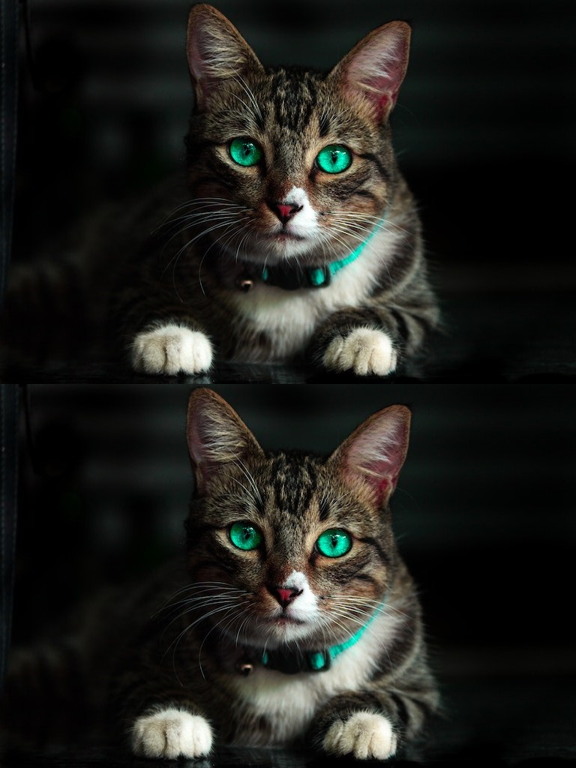

In [ ]:
stacked_imgs = stack_imgs([resized_img, resized_img])
print(f"Stacked Image Size: {stacked_imgs.size}")
stacked_imgs

In [ ]:
#| export
def img_save_path(image, # The image to be saved
                  save_dir, # The directory where the image will be saved
                  suffix='', # A suffix to add to the file name
                  hashlen=8, # The length of the image hash to use in the file name
                  fmt='PNG' # The format of the image
                 ):
    """
    Generate the file path to save the image.
    
    Returns:
    path (pathlib.Path): The file path to save the image
    """
    # Add a dash to the front of the suffix to the file name if it is provided
    # and hashlen is greater than 0
    suffix = f'-{suffix}' if len(suffix) > 0 and hashlen > 0 else suffix
    
    # Generate the SHA-256 hash of the image
    img_hash = hashlib.sha256(np.array(image)).hexdigest()[:hashlen]
    
    # Generate the file path by combining the save directory, image hash, suffix, and format
    return Path(f"{save_dir}/{img_hash}{suffix}.{fmt.lower()}")

In [ ]:
img_save_path(src_img, save_dir="./", suffix='cat')

Path('3dec29fe-cat.png')

In [ ]:
#| export
def avg_images(img_1:Image, # First image
               img_2:Image, # Second image
               weight:float=0.5): # Weightage given to the first image while averaging
    """
    This function takes two input images and a weight as input and returns the average of two images.
    """
    
    # Choose the mode with the most channels
    mode = max(img_1.mode, img_2.mode)
    
    # Convert both images to the selected mode
    img_1 = img_1.convert(mode)
    img_2 = img_2.convert(mode)
    
    # Calculate weightage for the second image
    weight_1 = np.float32(weight).clip(0, 1)
    weight_2 = 1 - weight_1
    
    # Multiply the first image with the weightage and convert to a numpy array
    img_array_1 = np.array(img_1, dtype=np.float32)*weight_1
    
    # Multiply the second image with the weightage and convert to a numpy array
    img_array_2 = np.array(img_2, dtype=np.float32)*weight_2
    
    # Calculate the average of the two arrays
    avg_array = img_array_1 + img_array_2
    
    # Convert the average array to an image
    avg_img = Image.fromarray(avg_array.astype(np.uint8)).convert(mode)
    
    return avg_img

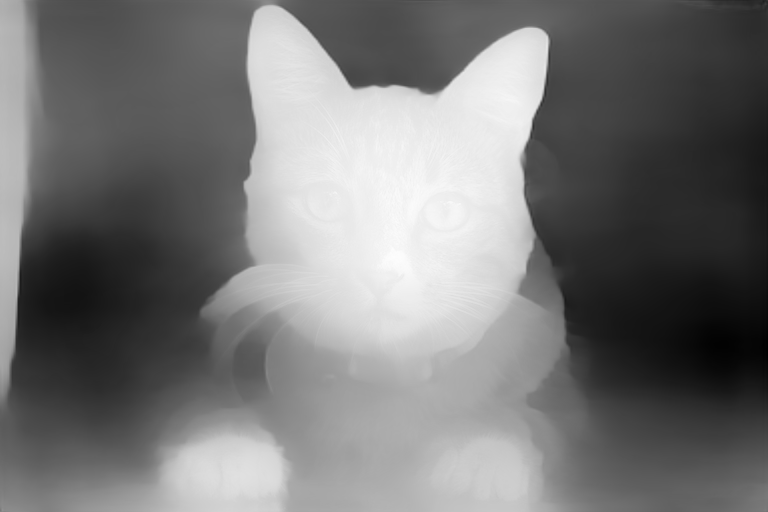

In [ ]:
img_1, img_2 = (Image.open(path) for path in img_paths)
avg_images(img_1.convert('L'), img_2, 0.05)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()